# Regression Analysis

### Imports

In [266]:
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

CONSENSUS_TIME = 'consensus_time'
OPINION_CHANGE_FREQUENCY = 'opinion_change_frequency'

FEATURES = [
    # 'clustering', 
    'closeness', 
    'n'
]

UNCORRELATED_FEATURE_SUBSET = [
    'clustering', 
    'closeness',
    'assortativity',
    'shannon_entropy'
]

In [267]:
dataset = pd.read_csv('../data/dataset.csv')

In [268]:
filtered_dataset = dataset.copy()
filtered_dataset.describe()

,clustering,closeness,n,consensus_time,opinion_change_frequency,groups
count,197.000000,197.000000,197.000000,197.000000,197.000000,197.0
mean,0.518071,0.697597,1259.989848,13.360355,312.219137,0.0
std,0.279386,0.141018,142.531987,25.570319,44.651281,0.0
min,0.019483,0.381968,1013.000000,1.430000,209.500000,0.0
25%,0.299717,0.588160,1146.000000,3.090000,276.150000,0.0
50%,0.518177,0.674908,1269.000000,5.350000,313.570000,0.0
75%,0.766184,0.810564,1387.000000,10.360000,343.690000,0.0
max,0.994529,0.994563,1493.000000,210.910000,488.420000,0.0


### Creating Scaler

In [269]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# dataset[FEATURES] = scaler.fit_transform(dataset[FEATURES])
# dataset[['consensus_time', 'opinion_change_frequency']] = scaler.fit_transform(dataset[['consensus_time', 'opinion_change_frequency']])

### Adjusted R2

In [270]:
from sklearn.metrics import r2_score

def adjusted_r2_score(y: np.array, y_hat: np.array, n: int, p: int):
    """
    Computes R² score. It decreases if many variables are introduced.
    n: number of observations in sample 
    p: number of independent variables
    """
    return 1 - ((1 - r2_score(y, y_hat)) * ((n - 1)/(n - p - 1)))

### Train Test Split

In [271]:
from sklearn.model_selection import train_test_split

# filtered_dataset.loc[:, FEATURES] = scaler.fit_transform(filtered_dataset[FEATURES])
# filtered_dataset.loc[:, 'opinion_change_frequency'] = scaler.fit_transform(np.array(filtered_dataset['opinion_change_frequency']).reshape(-1, 1))

y = filtered_dataset[CONSENSUS_TIME]
X = sm.add_constant(
   filtered_dataset[FEATURES]
)

X['closeness_log'] = np.log(X['closeness'])
FEATURES.append('closeness_log')
X['closeness_n'] = X['closeness'] * X['n']
FEATURES.append('closeness_n')

FEATURES.remove('closeness')
FEATURES.remove('n')


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, shuffle=True
)

X_train[FEATURES] = scaler.fit_transform(X_train[FEATURES])
X_test[FEATURES] = scaler.transform(X_test[FEATURES])


## Linear

In [272]:
mod = sm.OLS(
    endog=np.log1p(y_train), 
    exog=sm.add_constant(X_train[FEATURES]),
)
res = mod.fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:         consensus_time   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     507.2
Date:                Sat, 24 Aug 2024   Prob (F-statistic):           1.71e-68
Time:                        18:18:38   Log-Likelihood:                -35.439
No. Observations:                 157   AIC:                             76.88
Df Residuals:                     154   BIC:                             86.05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.0299      0.024     83.071

We still achieve a R-Squared of $0.99$ but without errors related to collinearity

In [273]:
y_pred = res.predict(sm.add_constant(X_test[FEATURES]))

In [274]:
adjusted_r2_score(y_pred, np.log1p(y_test), len(y_pred), len(UNCORRELATED_FEATURE_SUBSET))

0.7189763092789243

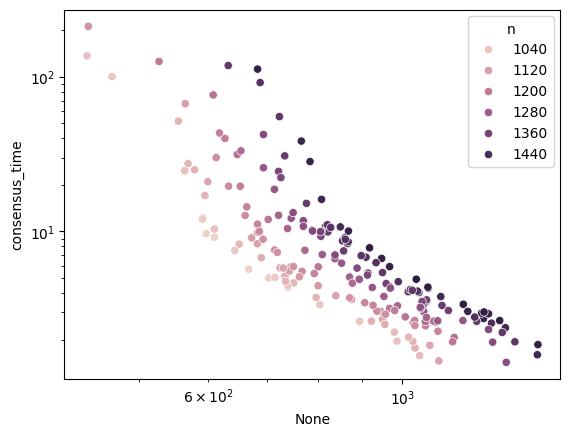

In [285]:
# sns.scatterplot(x=2-0.008*X['n']-0.8*X['closeness_log'], y=np.log1p(y), hue=X['n'])
sns.scatterplot(x=X['closeness']*X['n'], y=y, hue=X['n'])
plt.xscale('log')
plt.yscale('log')

### Residuals

<Axes: ylabel='consensus_time'>

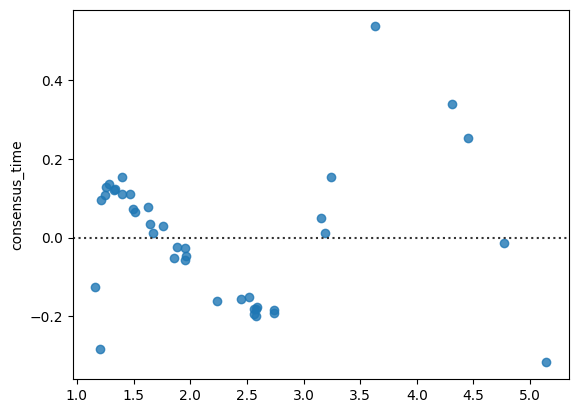

In [178]:
sns.residplot(x=y_pred, y=np.log1p(y_test))

Text(0, 0.5, 'log(Consensus Time)')

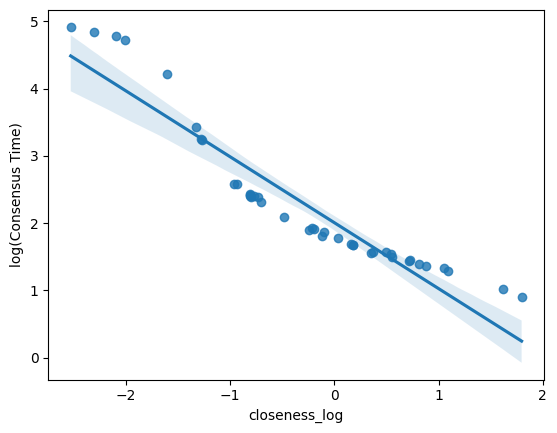

In [180]:
ax = sns.regplot(y=np.log1p(y_test), x=X_test['closeness_log'])
ax.set_ylabel('log(Consensus Time)')

## LASSO Regression
We intend to use Lasso for variable selection

In [134]:
from sklearn.linear_model import LassoCV

X_train[UNCORRELATED_FEATURE_SUBSET] = scaler.fit_transform(X_train[UNCORRELATED_FEATURE_SUBSET])
X_test[UNCORRELATED_FEATURE_SUBSET] = scaler.transform(X_test[UNCORRELATED_FEATURE_SUBSET])

lasso_cv = LassoCV(cv=20, random_state=0).fit(X_train[UNCORRELATED_FEATURE_SUBSET], np.log1p(y_train))

With fitted alpha, lets see statsmodels summary

In [82]:
mod = sm.OLS(
    endog=np.log1p(y_train), 
    exog=sm.add_constant(X_train[UNCORRELATED_FEATURE_SUBSET]),
)
res = mod.fit_regularized(
    method='elastic_net',
    alpha=lasso_cv.alpha_,
    L1_wt=1,
    refit=True
)

KeyError: "['clustering', 'assortativity', 'shannon_entropy'] not in index"

In [136]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         consensus_time   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 1.270e+04
Date:                Fri, 23 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:25:18   Log-Likelihood:                 278.91
No. Observations:                 446   AIC:                            -545.8
Df Residuals:                     441   BIC:                            -521.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               6.6197      0.006   10

In [154]:
y_pred = res.predict(sm.add_constant(X_test[UNCORRELATED_FEATURE_SUBSET]))
adjusted_r2_score(y_pred, np.log1p(y_test), len(y_pred), len(UNCORRELATED_FEATURE_SUBSET))

0.9937404631731812

<Axes: ylabel='consensus_time'>

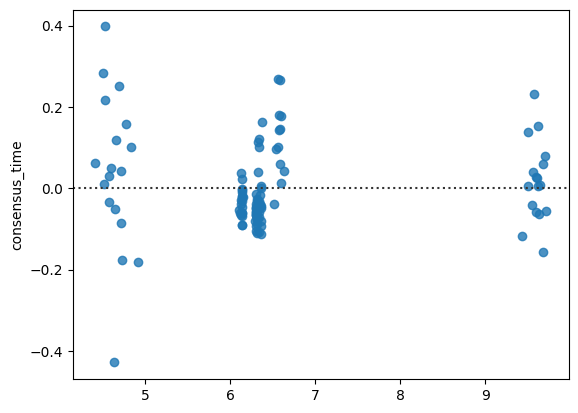

In [155]:
sns.residplot(x=y_pred, y=np.log1p(y_test))